## Comparing signature quality with signature similarity
### For PROGENy benchmark

In [1]:
#benchmark_progeny.py
#benchmark_tcga.py

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pickle as pckl
%matplotlib inline
sns.set_style("whitegrid")

import os

In [3]:
#check the random distribution of ROC AUCs
results=pd.read_csv('../results/benchmark/rocaucs/progeny/random_dist.csv',sep=',',header=0,index_col=0)
progeny=pd.read_csv('../results/benchmark/datasets/progeny_meta.csv',
                        sep=',',header=0,index_col=0)
progeny=progeny['pathway'].value_counts()
progeny=progeny[results.index]
background=pd.DataFrame(index=results.index,columns=['Mean','Sd','Size'])
background['Mean']=np.mean(results,1)
background['Sd']=np.std(results,1)
background['Size']=progeny

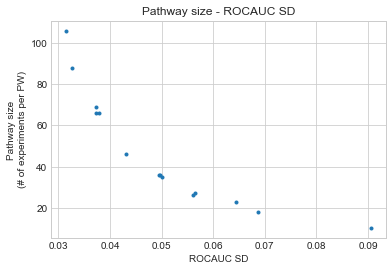

In [4]:
plt.plot(background['Sd'],background['Size'],'.')
plt.title('Pathway size - ROCAUC SD')
plt.xlabel('ROCAUC SD')
plt.ylabel('Pathway size\n(# of experiments per PW)')

In [6]:
#normalise ROCAUCS
fnames=os.listdir('../results/benchmark/rocaucs/progeny/')
fnames.remove('random_dist.csv')
data={}
for fname in fnames:
    data[fname[:-4]]=pd.read_csv('../results/benchmark/rocaucs/progeny/'+fname,sep=',',header=0,index_col=0)
for method in data.keys():
    for pw in background.index:
        data[method].loc[pw,:]=(data[method].loc[pw,:]-0.5)/background.loc[pw,'Sd']
for method in data.keys():
    data[method].to_csv('../results/benchmark/z_scores/progeny/%s.csv' % method, sep=',')

In [11]:
from scipy.stats import spearmanr as scor
from scipy.stats import pearsonr as pcor

In [343]:
def plot_similarity_and_quality(dname1,dname2,sim_type='jaccard',abs_type=False):
    sns.set_palette('GnBu',3)
    if abs_type:
        activity1=pd.read_csv('../results/benchmark/z_scores/progeny/%s_abs.csv' % dname1
                              ,sep=',',header=0,index_col=0).max()
        activity2=pd.read_csv('../results/benchmark/z_scores/progeny/%s_abs.csv' % dname2,
                              sep=',',header=0,index_col=0).max()
    else:
        activity1=pd.read_csv('../results/benchmark/z_scores/progeny/%s.csv' % dname1,
                              sep=',',header=0,index_col=0).abs().max()
        activity2=pd.read_csv('../results/benchmark/z_scores/progeny/%s.csv' % dname2,
                              sep=',',header=0,index_col=0).abs().max()
    if dname1<dname2:
        simname=dname1+'_'+dname2
    else:
        simname=dname2+'_'+dname1
    if sim_type=='jaccard':
        similarity=pd.read_csv('../results/similarity/%s_jaccard.csv' % simname,sep=',',header=0,index_col=0)
        if dname1<dname2:
            similarity1=similarity.max(1)
            similarity2=similarity.max(0)
        else:
            similarity1=similarity.max(0)
            similarity2=similarity.max(1)
    elif sim_type=='overlap':
        similarity=pd.read_csv('../results/similarity/%s_overlap.csv' % simname,sep=',',header=0,index_col=0)
        if dname1<dname2:
            similarity1=similarity.max(1)
            similarity2=similarity.max(0)
        else:
            similarity1=similarity.max(0)
            similarity2=similarity.max(1)
    else:
        similarity1=pd.read_csv('../results/similarity/%s_first.csv' % simname,sep=',',header=0,index_col=0)
        similarity2=pd.read_csv('../results/similarity/%s_second.csv' % simname,sep=',',header=0,index_col=0)
        if dname1<dname2:
            similarity1=similarity1.max(1)
            similarity2=similarity2.max(0)
        else:
            temp1=similarity2.max(0)
            temp2=similarity1.max(1)
            similarity1=temp1
            similarity2=temp2
    common1=list(set(similarity1.index)&set(activity1.index));similarity1=similarity1[common1];activity1=activity1[common1]
    common2=list(set(similarity2.index)&set(activity2.index));similarity2=similarity2[common2];activity2=activity2[common2]
    if dname1=='dorothea_AB':
        dname1='DoRothEA'
    if dname2=='dorothea_AB':
        dname2='DoRothEA'
    f,axs=plt.subplots(1,2,figsize=(8,4),dpi=300)
    sns.regplot(similarity1[common1],activity1[common1],ax=axs[0])
    axs[0].set_xlabel('Similarity to '+dname2)
    axs[0].set_ylabel('Quality of %s gene sets' % dname1)

    sns.regplot(similarity2[common2],activity2[common2],ax=axs[1])
    axs[1].set_xlabel('Similarity to '+dname1)
    axs[1].set_ylabel('Quality of %s gene sets' % dname2)
    print(pcor(similarity1[common1],activity1[common1]))
    print(pcor(similarity2[common2],activity2[common2]))

/Users/benceszalai/Library/Enthought/Canopy/edm/envs/Python3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-0.013589454799956956, 0.8662883263648056)
(0.3017234257306423, 2.927202029594482e-07)


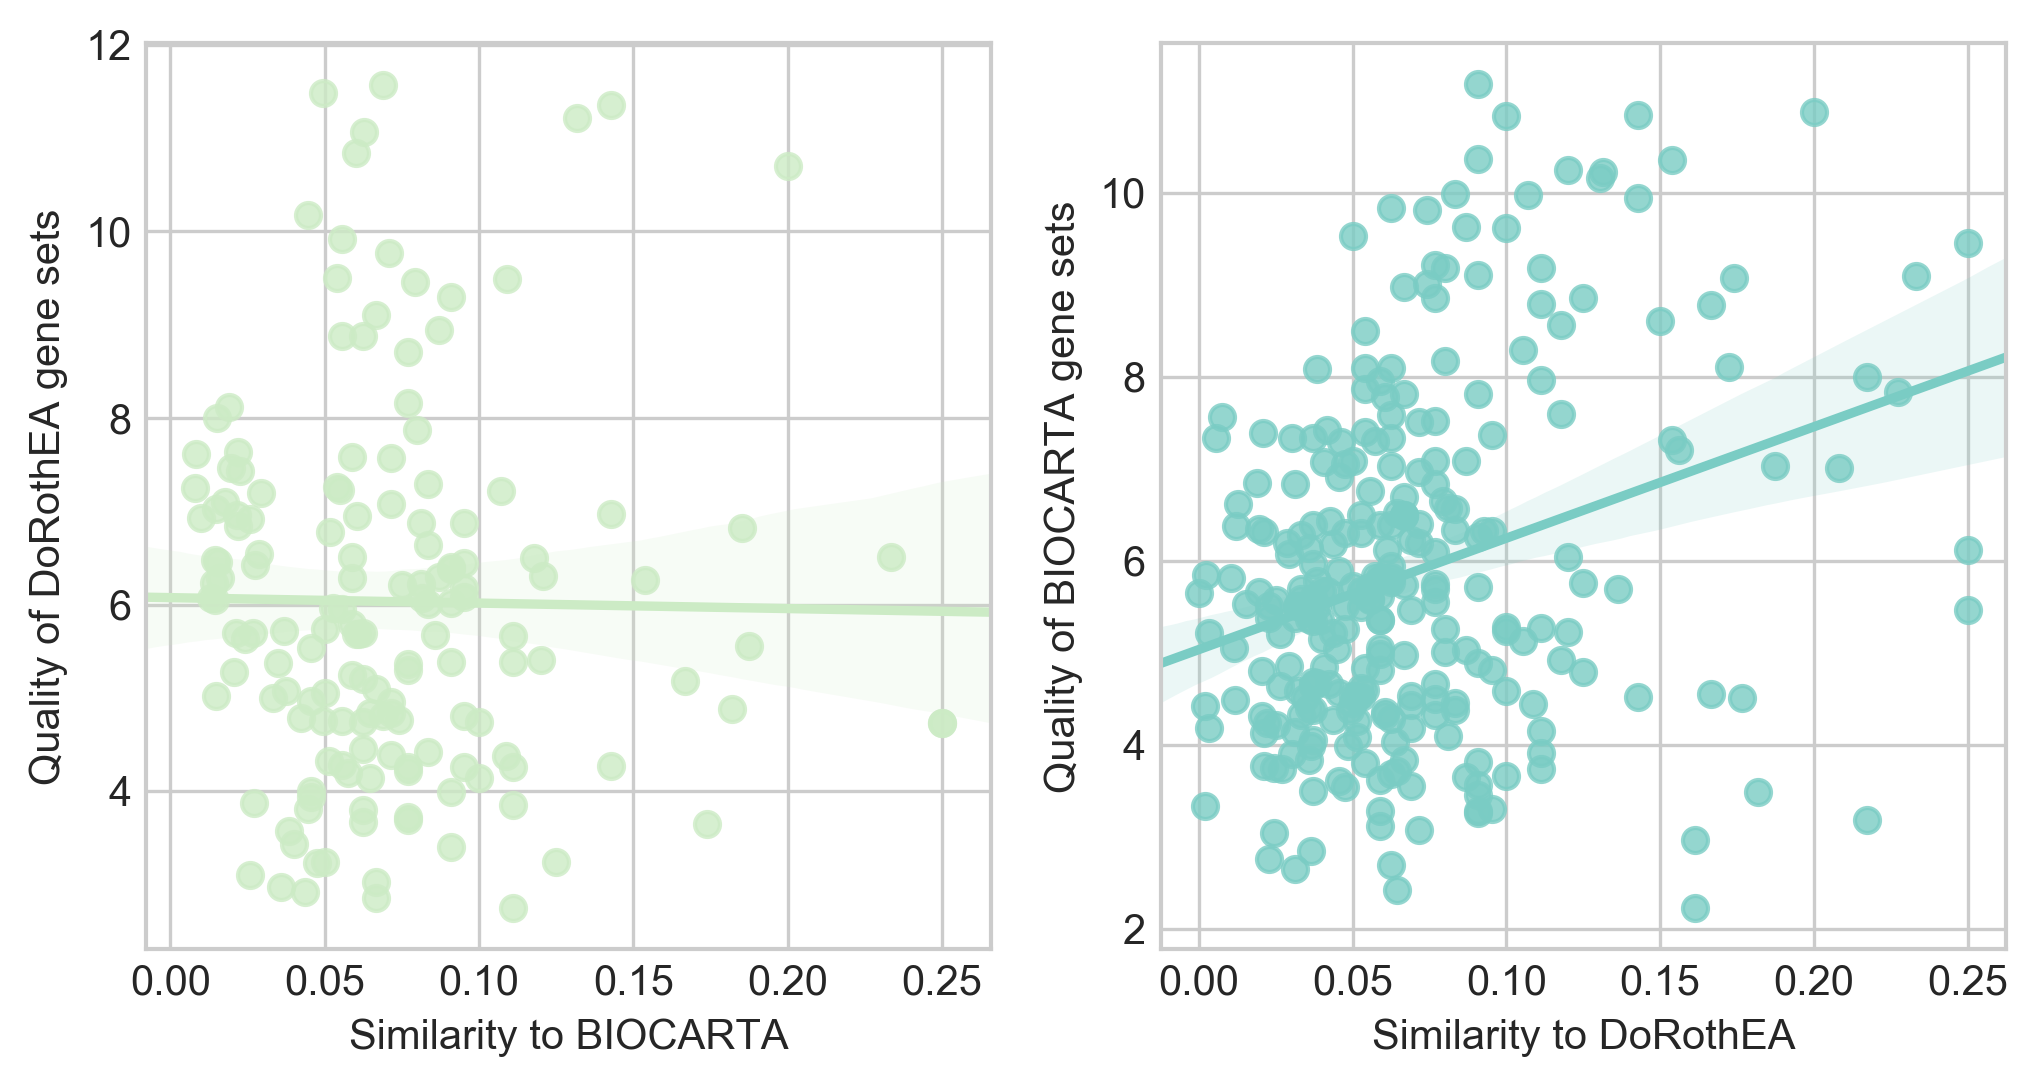

In [344]:
plot_similarity_and_quality('dorothea_AB','BIOCARTA',sim_type='jaccard',abs_type=False)

In [345]:
def calclate_similarity_and_quality(dname1,dname2,sim_type='jaccard',abs_type=False):
    if abs_type:
        activity1=pd.read_csv('../results/benchmark/z_scores/progeny/%s_abs.csv' % dname1
                              ,sep=',',header=0,index_col=0).abs().max()
        activity2=pd.read_csv('../results/benchmark/z_scores/progeny/%s_abs.csv' % dname2,
                              sep=',',header=0,index_col=0).abs().max()
    else:
        activity1=pd.read_csv('../results/benchmark/z_scores/progeny/%s.csv' % dname1,
                              sep=',',header=0,index_col=0).abs().max()
        activity2=pd.read_csv('../results/benchmark/z_scores/progeny/%s.csv' % dname2,
                              sep=',',header=0,index_col=0).abs().max()
    if dname1<dname2:
        simname=dname1+'_'+dname2
    else:
        simname=dname2+'_'+dname1
    if sim_type=='jaccard':
        similarity=pd.read_csv('../results/similarity/%s_jaccard.csv' % simname,sep=',',header=0,index_col=0)
        if dname1<dname2:
            similarity1=similarity.max(1)
            similarity2=similarity.max(0)
        else:
            similarity1=similarity.max(0)
            similarity2=similarity.max(1)
    elif sim_type=='overlap':
        similarity=pd.read_csv('../results/similarity/%s_overlap.csv' % simname,sep=',',header=0,index_col=0)
        if dname1<dname2:
            similarity1=similarity.max(1)
            similarity2=similarity.max(0)
        else:
            similarity1=similarity.max(0)
            similarity2=similarity.max(1)
    else:
        similarity1=pd.read_csv('../results/similarity/%s_first.csv' % simname,sep=',',header=0,index_col=0)
        similarity2=pd.read_csv('../results/similarity/%s_second.csv' % simname,sep=',',header=0,index_col=0)
        if dname1<dname2:
            similarity1=similarity1.max(1)
            similarity2=similarity2.max(0)
        else:
            temp1=similarity2.max(0)
            temp2=similarity1.max(1)
            similarity1=temp1
            similarity2=temp2
    common1=list(set(similarity1.index)&set(activity1.index));similarity1=similarity1[common1];activity1=activity1[common1]
    common2=list(set(similarity2.index)&set(activity2.index));similarity2=similarity2[common2];activity2=activity2[common2]
    
    r1=pcor(similarity1[common1],activity1[common1])[0]
    r2=pcor(similarity2[common2],activity2[common2])[0]
    
    return r1,r2

In [346]:
setnames=['dorothea_AB','CGP','BIOCARTA','KEGG','REACTOME']
results=pd.DataFrame(0.0,index=setnames,columns=setnames)
for dname1 in setnames:
    for dname2 in setnames:
        if dname1!=dname2:
            r1,r2=calclate_similarity_and_quality(dname1,dname2,'jaccard',False)
            results.loc[dname1,dname2]=r1
setnames=['DoRothEA','CGP','BIOCARTA','KEGG','REACTOME']
results.columns=setnames; results.index=setnames;

In [347]:
results['similarity_of']=results.index
results=results.melt(id_vars=['similarity_of'],value_vars=results.columns[:-1])
results.columns=['similarity_of','similarity_to','correlation']
fil=results['correlation']!=0
results=results[fil]

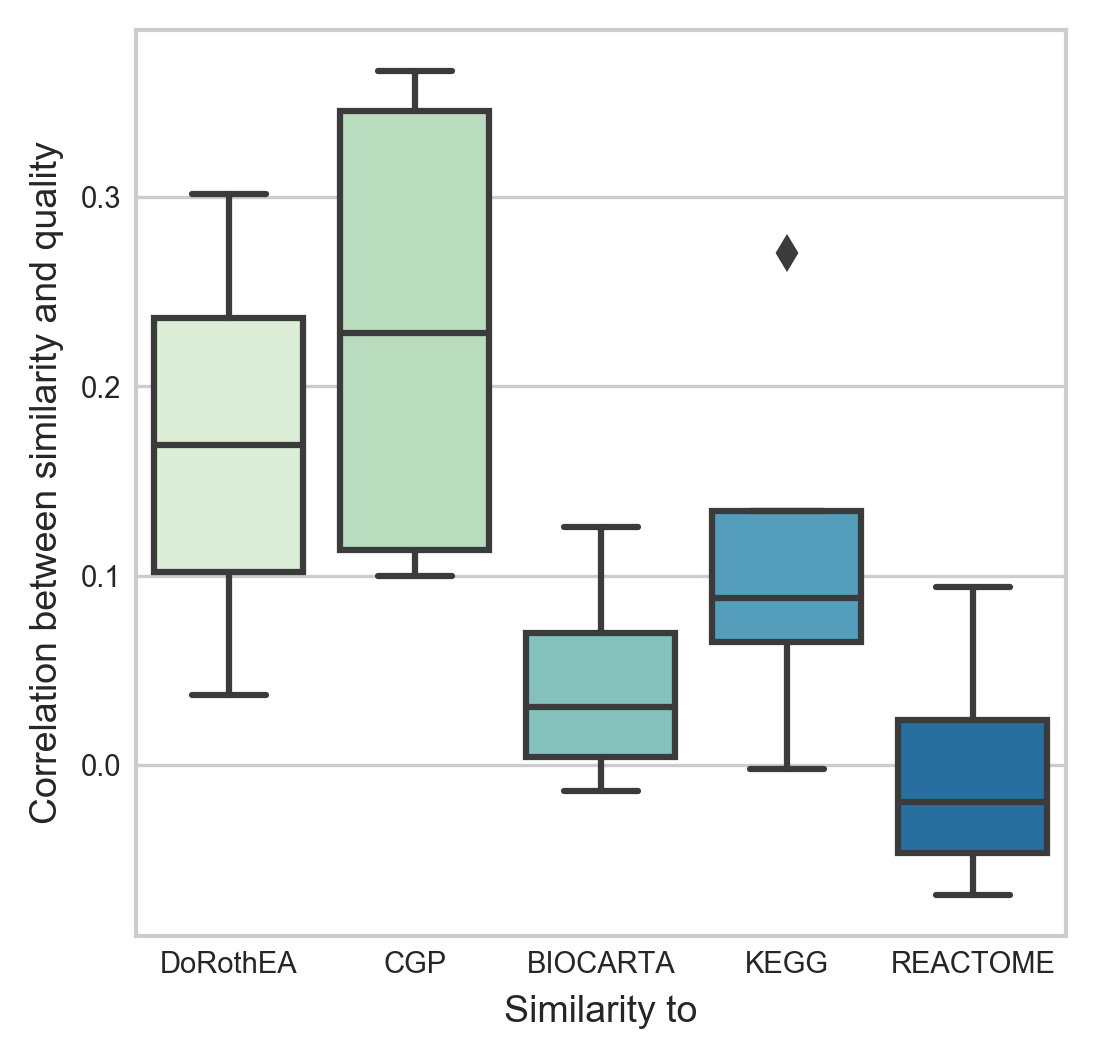

In [348]:
plt.figure(figsize=(4,4),dpi=300)
sns.set_palette('GnBu',5)
sns.boxplot(x='similarity_to',y='correlation',data=results)
plt.xticks(size=7)
plt.yticks(size=7)
plt.xlabel('Similarity to',size=9)
plt.ylabel('Correlation between similarity and quality',size=9)

In [349]:
results['data_driven']=0
fil=np.in1d(results['similarity_to'],['DoRothEA','CGP']); indexes=results.index[fil];
results.loc[indexes,'data_driven']=1

In [350]:
results

,similarity_of,similarity_to,correlation,data_driven
1,CGP,DoRothEA,0.214372,1
2,BIOCARTA,DoRothEA,0.301723,1
3,KEGG,DoRothEA,0.123915,1
4,REACTOME,DoRothEA,0.036820,1
5,DoRothEA,CGP,0.118132,1
7,BIOCARTA,CGP,0.366696,1
8,KEGG,CGP,0.099851,1
9,REACTOME,CGP,0.338577,1
10,DoRothEA,BIOCARTA,-0.013589,0
11,CGP,BIOCARTA,0.051136,0
